# Find a generator's Dispatch Unit ID (DUID) and download its SCADA data

In order to get data for a specific unit we need to know it's DUID, which acts as its name inside AEMO's Market Managment System database (MMS). In this example we will look at Daydream solar farm.

The mapping of station names to DUIDs is published by AEMO in the NEM Registration and Exemption List MS Excel file. Note that when this file is updated by AEMO they remove retired generators. The NEMOSIS table that contains the mapping from this file is called 'Generators and Scheduled Loads' its NEMOSIS wiki entry can be found [here](https://github.com/UNSW-CEEM/NEMOSIS/wiki/AEMO-Tables#generators-and-scheduled-loads-generators-and-scheduled-loads).

The SCADA data for generators is published by AEMO in the MMS table called DISPATCH_UNIT_SCADA, its NEMOSIS wiki entry can be found [here](https://github.com/UNSW-CEEM/NEMOSIS/wiki/AEMO-Tables#dispatch-unit-scada-dispatch_unit_scada).

Before you get started:
* getting plotly (the graphing package I've used) working in a jupyter notebook takes a little bit of extra work but the process is well documented here: https://plotly.com/python/getting-started/

In [1]:
import pandas as pd
import numpy as np
from datetime import timedelta
from nemosis import static_table, dynamic_data_compiler
import plotly.express as px

In [6]:
# Specify where we will be caching the raw AEMO data.
raw_data_cache = 'C:/Users/N.Gorman/Desktop/cache'

In [9]:
# Download the latest Generators and Scheduled Loads table. The 
# update_static_file=True argument forces nemosis to download a new copy of 
# file from AEMO even if a copy already exists in the cache.
dispatch_units = static_table(table_name='Generators and Scheduled Loads', 
                              raw_data_location=raw_data_cache,
                              update_static_file=False)
dispatch_units.head()

Retrieving static table Generators and Scheduled Loads.


,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
0,AETV Pty Ltd,Bairnsdale Power Station,VIC1,Generator,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,BDL01
1,AETV Pty Ltd,Bairnsdale Power Station,VIC1,Generator,Market,Scheduled,Fossil,Natural Gas,Combustion,Open Cycle Gas turbines (OCGT),Y,BDL02
2,AETV Pty Ltd,Chepstowe Wind Farm,VIC1,Generator,Market,Non-Scheduled,Wind,Wind,Renewable,Wind - Onshore,N,CHPSTWF1
3,AGL Hydro Partnership,Agl Kemps Creek,NSW1,Generator,Market,Non-Scheduled,Renewable/ Biomass / Waste,Landfill Methane / Landfill Gas,Combustion,Compression Reciprocating Engine,Y,AGLSITA1
4,AGL Hydro Partnership,Banimboola Power Station,VIC1,Generator,Market,Non-Scheduled,Hydro,Water,Renewable,Hydro - Gravity,Y,BAPS


In [10]:
# Use pandas filtering to find the DUID of Daydream solar farm
dispatch_units[dispatch_units['Station Name'].str.contains('dream')]

,Participant,Station Name,Region,Dispatch Type,Category,Classification,Fuel Source - Primary,Fuel Source - Descriptor,Technology Type - Primary,Technology Type - Descriptor,Aggregation,DUID
145,Daydream Solar Farm Pty Ltd ATF the Daydream S...,Daydream Solar Farm,QLD1,Generator,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,DAYDSF1
146,Daydream Solar Farm Pty Ltd ATF the Daydream S...,Daydream Solar Farm,QLD1,Generator,Market,Semi-Scheduled,Solar,Solar,Renewable,Photovoltaic Tracking Flat panel,Y,DAYDSF2


In [31]:
# Get the SCADA data assocaited with the two dispatch units for Daydream solar farm.
scada_data = dynamic_data_compiler(start_time='2021/05/01 00:00:00',
                                   end_time='2021/05/07 00:00:00',
                                   table_name='DISPATCH_UNIT_SCADA',
                                   raw_data_location=raw_data_cache)
scada_data = scada_data[scada_data['DUID'] == 'DAYDSF1']
scada_data.head()

Compiling data for table DISPATCH_UNIT_SCADA.
Returning DISPATCH_UNIT_SCADA.


,SETTLEMENTDATE,DUID,SCADAVALUE
311391,2021-05-01 01:05:00,DAYDSF1,0.0
311528,2021-05-01 00:35:00,DAYDSF1,0.0
312165,2021-05-01 01:10:00,DAYDSF1,0.0
312690,2021-05-01 01:20:00,DAYDSF1,0.0
312774,2021-05-01 01:35:00,DAYDSF1,0.0


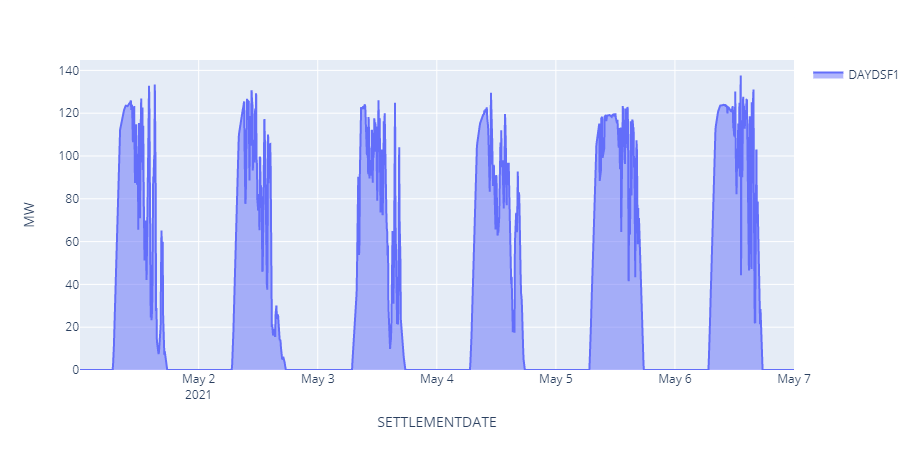

In [32]:
# Plot the results.
fig = px.area(scada_data, x='SETTLEMENTDATE', y='SCADAVALUE', color='DUID')
fig.update_layout(yaxis_title="MW", legend_title=None)
fig.show()